In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from datetime import datetime, timedelta
%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 100) # выведем больше строк
pd.set_option('display.max_columns', 100) # выведем больше колонок

In [3]:
# Фиксируем RANDOM_SEED, чтобы результаты были воспроизводимы
RANDOM_SEED = 42

In [4]:
df = pd.read_csv('main_task.csv')

In [5]:
df.columns = ['restaurant_id', 'city', 'cuisine_style', 'ranking', 'rating',
              'price_range', 'reviews_number', 'reviews', 'url_ta', 'id_ta']
df.head()

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_number,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   restaurant_id   40000 non-null  object 
 1   city            40000 non-null  object 
 2   cuisine_style   30717 non-null  object 
 3   ranking         40000 non-null  float64
 4   rating          40000 non-null  float64
 5   price_range     26114 non-null  object 
 6   reviews_number  37457 non-null  float64
 7   reviews         40000 non-null  object 
 8   url_ta          40000 non-null  object 
 9   id_ta           40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
df.describe()

,ranking,rating,reviews_number
count,40000.000000,40000.000000,37457.000000
mean,3676.028525,3.993037,124.825480
std,3708.749567,0.668417,295.666352
min,1.000000,1.000000,2.000000
25%,973.000000,3.500000,9.000000
50%,2285.000000,4.000000,33.000000
75%,5260.000000,4.500000,115.000000
max,16444.000000,5.000000,9660.000000


In [8]:
df.nunique()

restaurant_id     11909
city                 31
cuisine_style      9007
ranking           11936
rating                9
price_range           3
reviews_number     1459
reviews           33516
url_ta            39980
id_ta             39980
dtype: int64

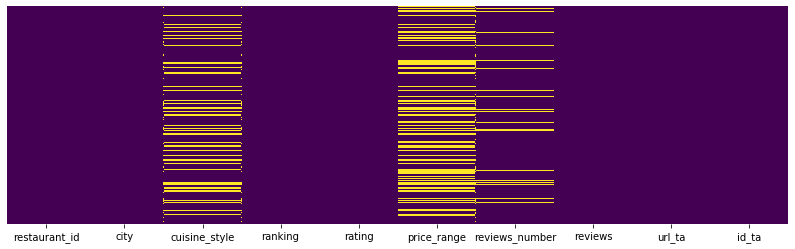

In [9]:
#Анализ пропусков в столбцах
plt.figure(figsize=(14, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap = 'viridis')

In [10]:
def analyse_numeric(datafr, column):
    '''Визуализирует распределения.
       Принимает параметрами DataFrame и строковое название столбца
       Печатает различные статистические показатели и строит гистограмму'''
    count = datafr[column].count()
    mean = datafr[column].mean()
    std = datafr[column].std()
    median = datafr[column].median()
    perc25 = datafr[column].quantile(0.25)
    perc75 = datafr[column].quantile(0.75)
    IQR = perc75 - perc25
    range_min = datafr[column].min()
    range_max = datafr[column].max()
    margin = (range_max - range_min)/10
    range_start = range_min - margin
    range_stop = range_max + margin
    range_ = (range_start, range_stop)
    outliers = datafr[column].loc[(datafr[column] < perc25 - 1.5*IQR) | (datafr[column] > perc75 + 1.5*IQR)]

    print('Количество: {}, Среднее: {:.3f}, Стандартное отклонение: {:.3f}.'.format(count, mean, std))
    print('Минимум: {}, 25-й перцентиль: {}, Медиана: {}, 75-й перцентиль: {}, Максимум: {}, IQR: {}.'
          .format(range_min, perc25, median, perc75, range_max, IQR))
    print('Количество пропусков в столбце: ', pd.isnull(datafr[column]).sum())
    print('Границы выбросов: [{f}, {l}].'.format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR)
          , 'Количество выбросов: ', len(outliers))

    datafr[column].loc[datafr[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)] \
                  .hist(bins = 30, range = range_, label = 'В границах выбросов')
    outliers.hist(bins = 30, range = range_, label = 'Выбросы')
    
    plt.legend()

## Осмотр и обработка данных и генерация новых признаков 

### restaurant_id

In [11]:
df.restaurant_id.nunique()

11909

### city

In [12]:
df_tmp = df.city.value_counts()
df_tmp

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: city, dtype: int64

#### Добавим столбец количества ресторанов в городе

In [13]:
df['rests'] = df['city'].apply(lambda x: df_tmp[x])

#### Поработаем с популяциями городов. Добавим столбец population двумя разными способми: из внешнего датасета worldcities.csv с https://kaggle.com и из Википедии, https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits и проверим, какой способ лучше.

#### Способ 1

In [14]:
#cities = pd.read_csv('.\data\worldcities.csv')
#cities.head()

In [15]:
def get_population(str_city):
    '''Возвращает популяцию города str_city'''
    if str_city.lower() == 'oporto': # Такого названия нет в датасете cities
        str_city = 'porto'
    return cities[cities.city_ascii.str.lower() == str_city.lower()]['population'].max()

In [16]:
#df['population'] = df.city.apply(lambda x: get_population(x))

#### Способ 2

In [17]:
population_dict = {
    'London': 9304016,
    'Paris': 2140526,
    'Madrid': 3348536,
    'Barcelona': 1620343,
    'Berlin': 3748148,
    'Milan': 1404239,
    'Rome': 2856133,
    'Prague': 1324277,
    'Lisbon': 506654,
    'Vienna': 1911728,
    'Amsterdam': 873555,
    'Brussels': 1209000,
    'Hamburg': 1841179,
    'Munich': 1471508,
    'Lyon': 515695,
    'Stockholm': 974073,
    'Budapest': 1752286,
    'Warsaw': 1790658,
    'Dublin': 554554,
    'Copenhagen': 626508,
    'Athens': 664046,
    'Edinburgh': 524930,
    'Zurich': 415367,
    'Oporto': 237559,
    'Geneva': 201818,
    'Krakow': 779115,
    'Oslo': 693491,
    'Helsinki': 648042,
    'Bratislava': 432864,
    'Luxembourg': 613894,
    'Ljubljana': 292988
}
df['population'] = df['city'].map(population_dict)

#### Пронормируем столбец population (получим значения в тысячах жителей)

In [18]:
df['population'] = df['population'] / 1000

#### Добавим столбец плотности ресторанов в городе

In [19]:
df['rest_density'] = df.rests / df.population

In [20]:
#Вот насчет этого подумать
#df['rest_density1'] = df.population / df.rests

#### Добавим признак capital

In [21]:
capitals = ['Paris', 'Stockholm', 'London', 'Berlin',
            'Bratislava', 'Vienna', 'Rome', 'Madrid',
            'Dublin', 'Brussels', 'Warsaw', 'Budapest', 'Copenhagen',
            'Amsterdam', 'Lisbon', 'Prague', 'Oslo',
            'Helsinki', 'Ljubljana', 'Athens', 'Luxembourg']
#df['capital'] = df['city'].apply(lambda x: x in capitals).astype('uint8')

#### Добавим dummies по городам

In [22]:
df = pd.concat([df, pd.get_dummies(df.city)], axis=1)
df.head(3)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_number,reviews,url_ta,id_ta,rests,population,rest_density,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,4897,2140.526,2.287755,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,820,974.073,0.841826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,5757,9304.016,0.618765,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Добавим признак country

In [23]:
countries_dict = {'Amsterdam': 'Netherlands',
             'Athens': 'Greece',
             'Barcelona': 'Spain',
             'Berlin': 'Germany',
             'Bratislava': 'Slovakia',
             'Brussels': 'Belgium',
             'Budapest': 'Hungary',
             'Copenhagen': 'Denmark',
             'Dublin': 'Ireland',
             'Edinburgh': 'UK',
             'Geneva': 'Switzerland',
             'Hamburg': 'Germany',
             'Helsinki': 'Finland',
             'Krakow': 'Poland',
             'Lisbon': 'Portugal',
             'Ljubljana': 'Slovenia',
             'London': 'UK',
             'Luxembourg': 'Luxembourg',
             'Lyon': 'France',
             'Madrid': 'Spain',
             'Milan': 'Italy',
             'Munich': 'Germany',
             'Oporto': 'Portugal',
             'Oslo': 'Norway',
             'Paris': 'France',
             'Prague': 'Czechia',
             'Rome': 'Italy',
             'Stockholm': 'Sweden',
             'Vienna': 'Austria',
             'Warsaw': 'Poland',
             'Zurich': 'Switzerland'}
df['country'] = df['city'].map(countries_dict)
df.country = df.country.apply(lambda s: s + '_')

In [24]:
df = pd.concat([df, pd.get_dummies(df.country)], axis=1)
df.head(5)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_number,reviews,url_ta,id_ta,rests,population,rest_density,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,country,Austria_,Belgium_,Czechia_,Denmark_,Finland_,France_,Germany_,Greece_,Hungary_,Ireland_,Italy_,Luxembourg_,Netherlands_,Norway_,Poland_,Portugal_,Slovakia_,Slovenia_,Spain_,Sweden_,Switzerland_,UK_
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,4897,2140.526,2.287755,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,France_,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,820,974.073,0.841826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Sweden_,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,5757,9304.016,0.618765,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,UK_,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,2155,3748.148,0.574951,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Germany_,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,893,1471.508,0.606860,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Germany_,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### cuisine_style

In [25]:
df.cuisine_style.value_counts()

['Italian']                                                                                                 1032
['French']                                                                                                   805
['Spanish']                                                                                                  695
['French', 'European']                                                                                       405
['Cafe']                                                                                                     403
                                                                                                            ... 
['French', 'International', 'European', 'Contemporary', 'Vegetarian Friendly', 'Gluten Free Options']          1
['Peruvian', 'Seafood', 'South American', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']       1
['Bar', 'French', 'Swiss', 'European']                                                          

In [26]:
df['cuisine_style_isna'] = pd.isna(df.cuisine_style).astype('uint8')

In [27]:
df.cuisine_style.fillna('1', inplace=True)

In [28]:
df['cuisine'] = df.cuisine_style.str[1:-1].str.split(', ')

In [29]:
df['cuisine'].head()

0              ['European', 'French', 'International']
1                                                   []
2    ['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...
3                                                   []
4    ['German', 'Central European', 'Vegetarian Fri...
Name: cuisine, dtype: object

In [30]:
len(df.explode('cuisine')['cuisine'].value_counts())

126

In [31]:
# Создадим новый признак - количество кухонь, представленных рестораном
df['cuisines_number'] = df['cuisine'].apply( lambda x: 1.0 if len(x)==0 else float(len(x)))

### ranking

Количество: 40000, Среднее: 3676.029, Стандартное отклонение: 3708.750.
Минимум: 1.0, 25-й перцентиль: 973.0, Медиана: 2285.0, 75-й перцентиль: 5260.0, Максимум: 16444.0, IQR: 4287.0.
Количество пропусков в столбце:  0
Границы выбросов: [-5457.5, 11690.5]. Количество выбросов:  2450


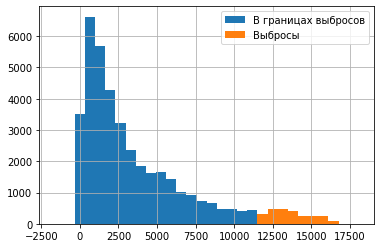

In [32]:
analyse_numeric(df, 'ranking')

In [33]:
# Удалим грубые выбросы
#df=df[df.ranking < 13000]

In [34]:
# Создадим новый признак путем нормирования ranking к количеству ресторанов в городе
df['ranking_norm_rests'] = df.ranking / df.rests

### rating

Количество: 40000, Среднее: 3.993, Стандартное отклонение: 0.668.
Минимум: 1.0, 25-й перцентиль: 3.5, Медиана: 4.0, 75-й перцентиль: 4.5, Максимум: 5.0, IQR: 1.0.
Количество пропусков в столбце:  0
Границы выбросов: [2.0, 6.0]. Количество выбросов:  340


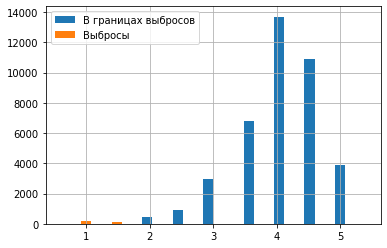

In [35]:
analyse_numeric(df, 'rating')

In [36]:
len(df[df['rating'] > 3.5])

28500

In [37]:
# Сгенерируем двоичный признак sentiment из целевой переменной, плохой или хороший ресторан, но используем его не напрямую,
# а для обучения текстового классификатора
#df['sentiment'] = df['rating'].apply(lambda x: 'good' if x > 3.5 else 'bad')
df['sentiment'] = df['rating'].apply(lambda x: 'bad' if x<4.0 else 'medium' if x==4 else 'good')

### price_range

In [38]:
df.price_range.value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: price_range, dtype: int64

In [39]:
df['price_range_isna'] = pd.isna(df.price_range).astype('uint8')

In [40]:
# Либо так:
#df['price_range_label'] = df.price_range.apply(lambda x: 1.0 if x=='$' else 2.0 if x=='$$ - $$$' else 4.0 if x=='$$$$' else np.nan)
# и заполним медианой по городам
#df.price_range_label = df.apply(lambda row: df[df.city==row.city].price_range_label.median() if pd.isna(row.price_range_label) \
#                                                                                     else row.price_range_label, axis=1)

# Либо так:
df['price_range_label'] = df.price_range.apply(lambda x: 2.5 if pd.isnull(x) else 1.0 if x=='$' else 2.5 if x=='$$ - $$$' else 4.0)

### reviews_number

Количество: 37457, Среднее: 124.825, Стандартное отклонение: 295.666.
Минимум: 2.0, 25-й перцентиль: 9.0, Медиана: 33.0, 75-й перцентиль: 115.0, Максимум: 9660.0, IQR: 106.0.
Количество пропусков в столбце:  2543
Границы выбросов: [-150.0, 274.0]. Количество выбросов:  4348


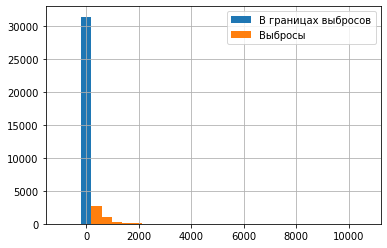

In [41]:
analyse_numeric(df, 'reviews_number')

In [42]:
df['reviews_number_isna'] = pd.isna(df.reviews_number).astype('uint8')

In [43]:
len(df[df.reviews_number > 2000])

140

In [44]:
#Удалим грубые выбросы
#df=df[df.reviews_number < 2000]

In [45]:
#!!! Нужно пробовать одно из двух!!!
# Замена пропусков медианой по соответствующему городу
#df.reviews_number = df.apply(lambda row: df[df.city==row.city].reviews_number.median() if pd.isna(row.reviews_number) \
#                                                                                     else row.reviews_number, axis=1)

# Замена пропусков нулевым значением
df.reviews_number.fillna(0, inplace=True)

In [46]:
# Нормируем количество отзывов к населению города
df['reviews_number_norm'] = df.reviews_number / df.population

### reviews

In [47]:
#pd.DataFrame(df.reviews.value_counts())
df.reviews.value_counts()

[[], []]                                                                                                                              6471
[['Happened to drop in', 'Right for a quick bite'], ['11/30/2016', '06/20/2015']]                                                        2
[['ok for beer, not for dinner'], ['12/20/2017']]                                                                                        2
[['Simply Excellent!', 'Modern!'], ['10/22/2017', '08/29/2017']]                                                                         2
[['Whenever in Madrid, we never miss this gem...', 'Underrated sushi restaurant with very good...'], ['04/11/2017', '12/02/2016']]       2
                                                                                                                                      ... 
[['Great value for a bite to eat whilst out a...', 'Terrible staff'], ['02/20/2016', '11/08/2014']]                                      1
[['Awesome culinary adventu

In [48]:
df['reviews_dates'] = df['reviews'].str.findall('\d+/\d+/\d+')
df[['reviews', 'reviews_dates']].head()

,reviews,reviews_dates
0,"[['Good food at your doorstep', 'A good hotel ...","[12/31/2017, 11/20/2017]"
1,"[['Unique cuisine', 'Delicious Nepalese food']...","[07/06/2017, 06/19/2016]"
2,"[['Catch up with friends', 'Not exceptional'],...","[01/08/2018, 01/06/2018]"
3,"[[], []]",[]
4,"[['Best place to try a Bavarian food', 'Nice b...","[11/18/2017, 02/19/2017]"


In [49]:
df['review1_date'] = df.reviews_dates.apply(lambda x: x[0] if len(x)>0 else None)
df['review1_date']

0        12/31/2017
1        07/06/2017
2        01/08/2018
3              None
4        11/18/2017
            ...    
39995    12/16/2017
39996    12/21/2017
39997    11/03/2016
39998    07/11/2017
39999    01/31/2016
Name: review1_date, Length: 40000, dtype: object

In [50]:
#На этом значении в следующей ячейке возникает ошибка
df[df['review1_date']=='29/9/2016']

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_number,reviews,url_ta,id_ta,rests,population,rest_density,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,country,Austria_,Belgium_,Czechia_,Denmark_,Finland_,France_,Germany_,Greece_,Hungary_,Ireland_,Italy_,Luxembourg_,Netherlands_,Norway_,Poland_,Portugal_,Slovakia_,Slovenia_,Spain_,Sweden_,Switzerland_,UK_,cuisine_style_isna,cuisine,cuisines_number,ranking_norm_rests,sentiment,price_range_isna,price_range_label,reviews_number_isna,reviews_number_norm,reviews_dates,review1_date
23348,id_450,Geneva,"['French', 'European']",453.0,4.0,$$ - $$$,48.0,"[['lunch 29/9/2016', 'Unplanned Great Dinner']...",/Restaurant_Review-g188057-d2706773-Reviews-Le...,d2706773,481,201.818,2.383335,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Switzerland_,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,"['French', 'European']",2.0,0.941788,medium,0,2.5,0,0.237838,"[29/9/2016, 09/30/2016, 08/25/2016]",29/9/2016


In [51]:
#df[df['review1_date']=='29/9/2016'].review1_date = '09/29/2016'
df.loc[23348, 'review1_date'] = '09/29/2016'

In [52]:
df['review1_date_d'] = df.review1_date.apply(lambda x: None if pd.isna(x) else datetime.strptime(x, '%m/%d/%Y'))
df['review1_date_d']

0       2017-12-31
1       2017-07-06
2       2018-01-08
3              NaT
4       2017-11-18
           ...    
39995   2017-12-16
39996   2017-12-21
39997   2016-11-03
39998   2017-07-11
39999   2016-01-31
Name: review1_date_d, Length: 40000, dtype: datetime64[ns]

In [53]:
df['review2_date'] = df.reviews_dates.apply(lambda x: x[1] if len(x)>1 else None)
df['review2_date']

0        11/20/2017
1        06/19/2016
2        01/06/2018
3              None
4        02/19/2017
            ...    
39995    11/12/2017
39996    12/12/2017
39997    04/12/2008
39998    06/18/2017
39999    07/04/2012
Name: review2_date, Length: 40000, dtype: object

In [54]:
df['review2_date_d'] = df.reviews_dates.apply(lambda x: datetime.strptime(x[1], '%m/%d/%Y') if len(x)>1 else None)
df['review2_date_d']

0       2017-11-20
1       2016-06-19
2       2018-01-06
3              NaT
4       2017-02-19
           ...    
39995   2017-11-12
39996   2017-12-12
39997   2008-04-12
39998   2017-06-18
39999   2012-07-04
Name: review2_date_d, Length: 40000, dtype: datetime64[ns]

In [55]:
df['review1_date_d'].max()

Timestamp('2018-02-26 00:00:00')

In [56]:
df['review2_date_d'].max()

Timestamp('2018-02-26 00:00:00')

In [57]:
#datetime(2019, 4, 1, 18, 59, 44) - так можно создать DateTime
(df.review1_date_d - df.review2_date_d).dt.days.max()

3207.0

In [58]:
# Создадим новый признак - количество дней между отзывами
df['days_between'] = abs((df.review1_date_d - df.review2_date_d).dt.days)
df['days_between']

0          41.0
1         382.0
2           2.0
3           NaN
4         272.0
          ...  
39995      34.0
39996       9.0
39997    3127.0
39998      23.0
39999    1306.0
Name: days_between, Length: 40000, dtype: float64

Количество: 28973, Среднее: 141.709, Стандартное отклонение: 221.167.
Минимум: 0.0, 25-й перцентиль: 20.0, Медиана: 67.0, 75-й перцентиль: 173.0, Максимум: 3207.0, IQR: 153.0.
Количество пропусков в столбце:  11027
Границы выбросов: [-209.5, 402.5]. Количество выбросов:  2292


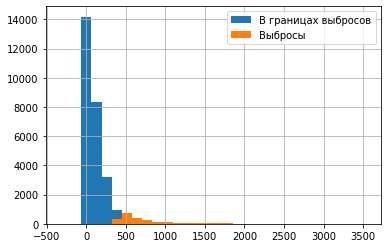

In [59]:
analyse_numeric(df, 'days_between')

In [60]:
len(df[df.days_between > 1000])

382

In [61]:
#df[df.days_between > 2000]

In [62]:
len(df[df.days_between < 0])

0

In [63]:
# Удалим грубые выбросы
#df=df[df.days_between <= 2000]

In [64]:
# !!! Пока заполним пропуски медианой
df.days_between.fillna(df.days_between.median(), inplace=True)

### url_ta

In [65]:
df.url_ta.value_counts()

/Restaurant_Review-g187514-d4600226-Reviews-Cafeteria_Teresa-Madrid.html                                  2
/Restaurant_Review-g187514-d11674463-Reviews-Beerhouse-Madrid.html                                        2
/Restaurant_Review-g187514-d9802625-Reviews-La_Vie_en_Doux-Madrid.html                                    2
/Restaurant_Review-g187514-d8753348-Reviews-Tropecientos-Madrid.html                                      2
/Restaurant_Review-g187514-d3685055-Reviews-Shukran-Madrid.html                                           2
                                                                                                         ..
/Restaurant_Review-g190356-d10344116-Reviews-Quatorze_degres_Bar_a_vins-Luxembourg_City.html              1
/Restaurant_Review-g274924-d951686-Reviews-Liviano_Restaurant-Bratislava_Bratislava_Region.html           1
/Restaurant_Review-g187265-d3854375-Reviews-Brasserie_Midi_Minuit-Lyon_Rhone_Auvergne_Rhone_Alpes.html    1
/Restaurant_Review-g186605-d

### id_ta

In [66]:
df.id_ta.value_counts()

d3685055     2
d13002276    2
d1315077     2
d9877640     2
d697406      2
            ..
d4985377     1
d10813188    1
d2478446     1
d2508368     1
d8659203     1
Name: id_ta, Length: 39980, dtype: int64

In [67]:
# Преобразуем id_ta в числа (будет новый признак):
df['id_ta_num'] = df['id_ta'].str[1:].astype('int64')#'float64'

## Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 83 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   restaurant_id        40000 non-null  object        
 1   city                 40000 non-null  object        
 2   cuisine_style        40000 non-null  object        
 3   ranking              40000 non-null  float64       
 4   rating               40000 non-null  float64       
 5   price_range          26114 non-null  object        
 6   reviews_number       40000 non-null  float64       
 7   reviews              40000 non-null  object        
 8   url_ta               40000 non-null  object        
 9   id_ta                40000 non-null  object        
 10  rests                40000 non-null  int64         
 11  population           40000 non-null  float64       
 12  rest_density         40000 non-null  float64       
 13  Amsterdam            40000 non-

In [69]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['restaurant_id', 'rating', 'city', 'cuisine_style', 'price_range', 'url_ta', 'id_ta', #, 'reviews'
             'cuisine', 'reviews_dates', 'review1_date', 'review2_date', 'review1_date_d',
             'review2_date_d', 'population', 'rests', 'country', 'sentiment'], axis = 1)
y = df['rating']

# Здесь пробуем использовать созданный ранее столбец sentiment как двоичную целевую переменную
y_sent = df['sentiment']

X.head(3)

,ranking,reviews_number,reviews,rest_density,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Austria_,Belgium_,Czechia_,Denmark_,Finland_,France_,Germany_,Greece_,Hungary_,Ireland_,Italy_,Luxembourg_,Netherlands_,Norway_,Poland_,Portugal_,Slovakia_,Slovenia_,Spain_,Sweden_,Switzerland_,UK_,cuisine_style_isna,cuisines_number,ranking_norm_rests,price_range_isna,price_range_label,reviews_number_isna,reviews_number_norm,days_between,id_ta_num
0,5570.0,194.0,"[['Good food at your doorstep', 'A good hotel ...",2.287755,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,1.137431,0,2.5,0,0.090632,41.0,1912643
1,1537.0,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",0.841826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1.0,1.874390,1,2.5,0,0.010266,382.0,7992032
2,353.0,688.0,"[['Catch up with friends', 'Not exceptional'],...",0.618765,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7.0,0.061317,0,4.0,0,0.073947,2.0,8632781


In [70]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test, y_sent_train, y_sent_test = train_test_split(X, y, y_sent, test_size=0.25)#, random_state=RANDOM_SEED

In [71]:
#Убираем нечисловой признак 'reviews'
X1 = X.drop(['reviews'], axis = 1)
X_train1 = X_train.drop(['reviews'], axis = 1)
X_test1 = X_test.drop(['reviews'], axis = 1)

## Создание, обучение и тестирование модели

In [72]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)#, random_state=RANDOM_SEED

# Обучаем модель на тестовом наборе данных
regr.fit(X_train1, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = (regr.predict(X_test1)*2).round()/2

In [73]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1752


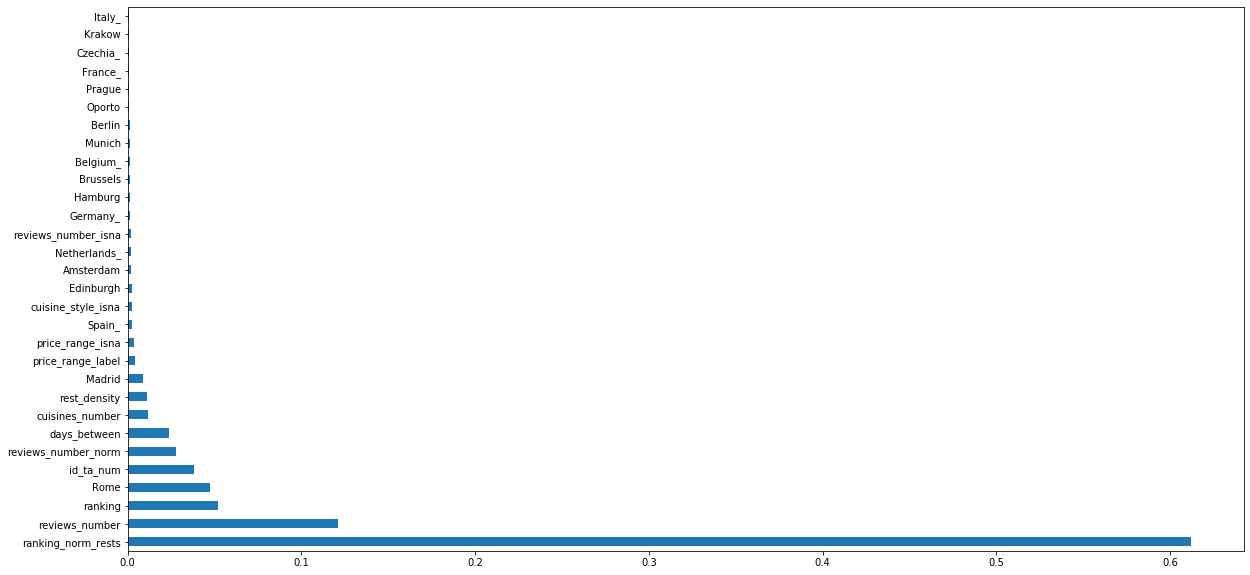

In [74]:
# Отображаем признаки, отсортированные по их значимости
plt.rcParams['figure.figsize'] = (20, 10)
feat_importances = pd.Series(regr.feature_importances_, index=X1.columns)
feat_importances.nlargest(30).plot(kind='barh')

In [75]:
from ipython_exit import exit

In [76]:
exit()

IpyExit: 

## Попробуем текстовую классификацию

In [ ]:
import string
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_extraction.text import HashingVectorizer
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [ ]:
pd.options.mode.chained_assignment = None

#### Создадим X с преобразованными текстами reviews и y с raiting в текстовом формате:

In [ ]:
# Х - данные с текстами отзывлов, у - целевая переменная (рейтинги ресторанов)

# Для удаления знаков пунктуации
tt = str.maketrans(dict.fromkeys(string.punctuation))

# Удаляем знаки пунктуации и цифры (очищенные reviews)
X_nlp = X.reviews.str.translate(tt).str.lower().apply(lambda s: re.sub(r'\b\d+\b', '', s))
X_nlp_train = X_train.reviews.str.translate(tt).str.lower().apply(lambda s: re.sub(r'\b\d+\b', '', s))
X_nlp_test = X_test.reviews.str.translate(tt).str.lower().apply(lambda s: re.sub(r'\b\d+\b', '', s))

# Преобразуем числовую переменную в текстовую
y_nlp = y.astype('str')
y_nlp_train = y_train.astype('str')
y_nlp_test = y_test.astype('str')

# Заполним пустые значения строкой 'empty'
X_nlp = X_nlp.apply(lambda s: 'empty' if s.strip() == '' else s)
X_nlp_train = X_nlp_train.apply(lambda s: 'empty' if s.strip() == '' else s)
X_nlp_test = X_nlp_test.apply(lambda s: 'empty' if s.strip() == '' else s)

In [ ]:
def text_transformer(text):
    '''Дальнейшая предобработка текстов:
       Стеминг и удаление stop-слов'''
    stemmer = SnowballStemmer("english")
    singles = [stemmer.stem(word) for word in text.split()]
    text = ' '.join(singles)

    #Удаление незначимых слов
    stw = ['a', 'at', 'on', 'of', 'and', 'or', 'in', 'for', 'at', 'empty' ]
    remove = r'\b(' + '|'.join(stw) + r')\b'  
    text = re.sub(remove, ' ', text)
    
    text = re.sub( r'\b\w\b', '', text ) # удаление отдельно стоящих букв

    return  text

In [ ]:
X_nlp = X_nlp.apply(lambda s: text_transformer(s))
X_nlp_train = X_nlp_train.apply(lambda s: text_transformer(s))
X_nlp_test = X_nlp_test.apply(lambda s: text_transformer(s))

In [ ]:
# Создаем и обучаем первый полноценный классификатор
text_clf1 = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1, 2))), #stop_words={'english'},
                      ('clf', SGDClassifier(loss='hinge'))])#, random_state=RANDOM_SEED
text_clf1.fit(X_nlp_train, y_nlp_train)

In [ ]:
# Оцениваем нашу первую NLP-модель

predicted = text_clf1.predict(X_nlp) # Это, наверное, не нужно

predicted_train = text_clf1.predict(X_nlp_train)
print("[i] accuracy train: ", accuracy_score(y_nlp_train , predicted_train) )
    
predicted_test = text_clf1.predict(X_nlp_test)
print("[i] accuracy test: ", accuracy_score(y_nlp_test , predicted_test) )

In [ ]:
# Создаем и обучаем второй классификатор для предсказания тональности
text_clf2 = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1, 2))), #stop_words={'english'},
                      ('clf', SGDClassifier(loss='hinge'))])#, random_state=RANDOM_SEED
text_clf2.fit(X_nlp_train, y_sent_train)

In [ ]:
# Оцениваем нашу вторую NLP-модель

predicted2 = text_clf2.predict(X_nlp) # Это, наверное, не нужно

predicted2_train = text_clf2.predict(X_nlp_train)
print("[i] accuracy train: ", accuracy_score(y_sent_train , predicted2_train) )
    
predicted2_test = text_clf2.predict(X_nlp_test)
print("[i] accuracy test: ", accuracy_score(y_sent_test , predicted2_test) )

In [ ]:
# #Читерский подход: Обучаем модель на всей выборке и делаем предсказания на тех же данных, на которых обучалась модель
# text_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1, 4))), #stop_words={'english'},
#                      ('clf', SGDClassifier(loss='hinge'))])
# text_clf.fit(X_nlp, y_nlp)

# predicted = text_clf.predict(X_nlp)
# predicted_train = text_clf.predict(X_nlp_train)
# predicted_test = text_clf.predict(X_nlp_test)

In [ ]:
#Убираем нечисловой признак 'reviews'
X1 = X.drop(['reviews'], axis = 1)
X_train1 = X_train.drop(['reviews'], axis = 1)
X_test1 = X_test.drop(['reviews'], axis = 1)

#### Создаем новый признак 'rating_pr', предсказанный по текстам reviews:

In [ ]:
# X1['rating_pr'] = predicted.astype('float64')
# X_train1['rating_pr'] = predicted_train.astype('float64')
# X_test1['rating_pr'] = predicted_test.astype('float64')

#### Создаем новый признак 'rating_sent', предсказанный по текстам reviews:

In [ ]:
X1['rating_sent'] = predicted2
#X1['rating_sent'] = X1['rating_sent'].apply(lambda s: 1.0 if s=='good' else 0.0)
X1['rating_sent'] = X1['rating_sent'].apply(lambda s: 2.0 if s=='good' else 1.0 if s=='medium' else 0.0)
X_train1['rating_sent'] = predicted2_train
#X_train1['rating_sent'] = X_train1['rating_sent'].apply(lambda s: 1.0 if s=='good' else 0.0)
X_train1['rating_sent'] = X_train1['rating_sent'].apply(lambda s: 2.0 if s=='good' else 1.0 if s=='medium' else 0.0)
X_test1['rating_sent'] = predicted2_test
#X_test1['rating_sent'] = X_test1['rating_sent'].apply(lambda s: 1.0 if s=='good' else 0.0)
X_test1['rating_sent'] = X_test1['rating_sent'].apply(lambda s: 2.0 if s=='good' else 1.0 if s=='medium' else 0.0)

#### И заново обучаем модель с новым признаком

## Создание, обучение и тестирование модели с новыми признаками 'rating_pr' и 'rating_sent'

In [ ]:
regr = RandomForestRegressor(n_estimators=100)#, random_state=RANDOM_SEED
regr.fit(X_train1, y_train)
y_pred = (regr.predict(X_test1)*2).round()/2

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# Отображаем признаки, отсортированные по их значимости
plt.rcParams['figure.figsize'] = (20, 10)
feat_importances = pd.Series(regr.feature_importances_, index=X1.columns)
feat_importances.nlargest(30).plot(kind='barh')

In [ ]:
# # составляем список важнейших признаков
# main_features = feat_importances.nlargest(55).index.tolist()

In [ ]:
# feat_importances.sort_values()

In [ ]:
# # Еще раз копируем датасет, оставив только важнейшие признаки:
# X = X[main_features].copy()
# X_train = X_train[main_features].copy()
# X_test = X_test[main_features].copy()

In [ ]:
# X.head()

In [ ]:
# # Пересоздаем модель, используя только самые важные признаки
# regr = RandomForestRegressor(n_estimators=100)
# regr.fit(X_train, y_train)
# y_pred = (regr.predict(X_test)*2).round()/2
# print('MAE:', metrics.mean_absolute_error(y_test, y_pred))